# Demo workbook exploring kernel class functionality

In [1]:
import os
import sys
import time
sys.path.append(os.path.join(os.path.abspath(""), "..")

from app.imager import ImageLoader, DefectViewer
from app.transforms import *

In [2]:
# Load 10 images of class 'FrontGridInterruption'
n_samples = 3  # Number of samples of images
image_df = ImageLoader(defect_class='FrontGridInterruption') << n_samples  # Load n_sample images of class 'FrontGridInterruption'

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [3]:
# Get n_samples of the defect type 'FrontGridInterruption' and return an image array
images = DefectViewer() << image_df

## Sobel filter

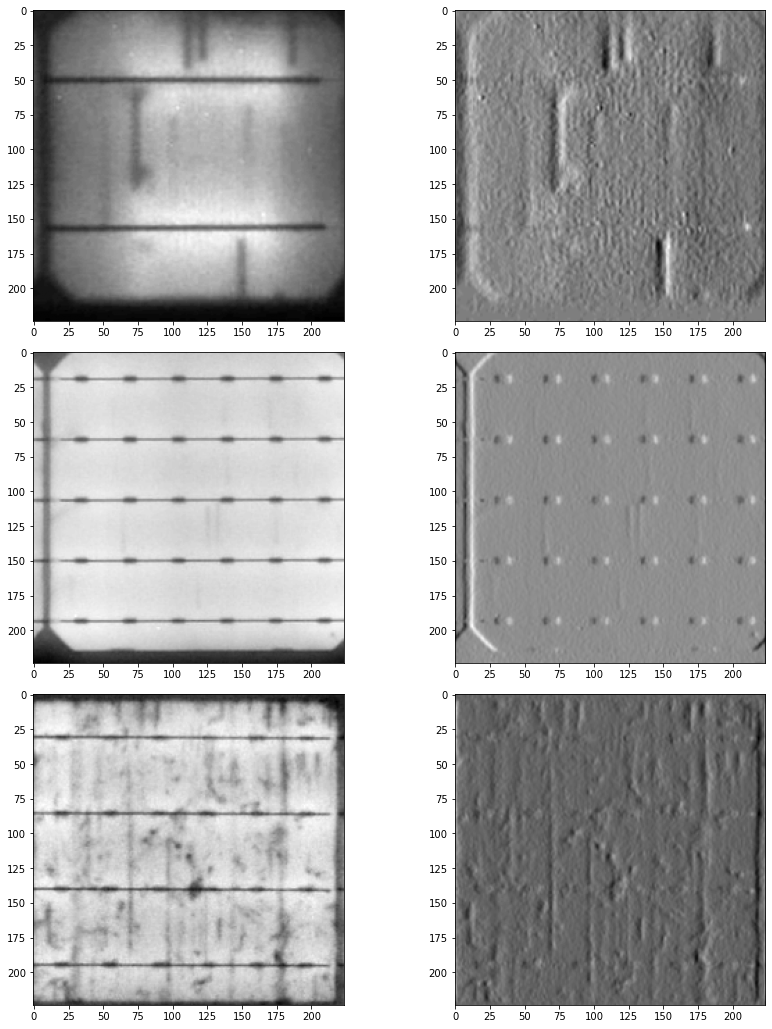

In [6]:
sobel = Show(do_show=True) << (Convolve(axis=-2, mode='wrap') \
                               << (CreateKernel(dim=2, kernel='sobel', axis=0) \
                                   << images))

## Prewitt Filter

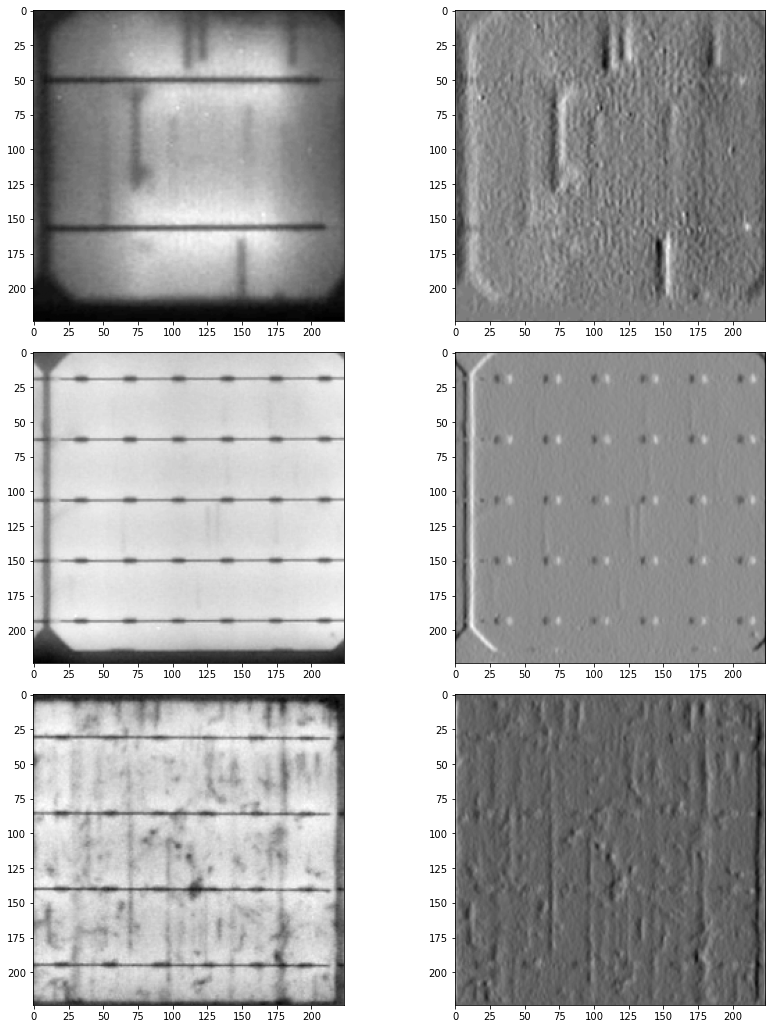

In [9]:
prewitt = Show(do_show=True) << (Convolve(axis=-2, mode='wrap') \
                                 << (CreateKernel(dim=2, kernel='prewitt', axis=0) \
                                     << images))

## Gaussian - mean/sigma specified

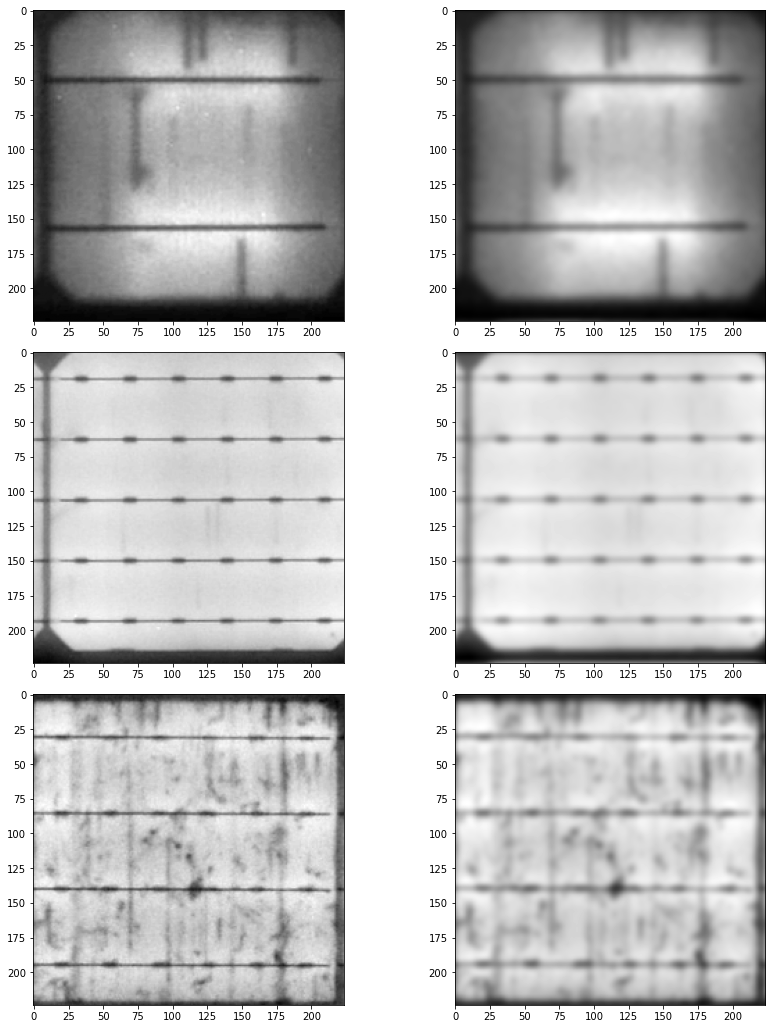

In [8]:
gaussian = Show(do_show=True) << (Convolve(axis=-2, mode='wrap') \
                                 << (CreateKernel(dim=2, kernel='gaussian', convolve_mode='full',
                                                  boundary='wrap', size=10, std=2) \
                                     << images))

## Custom Filter

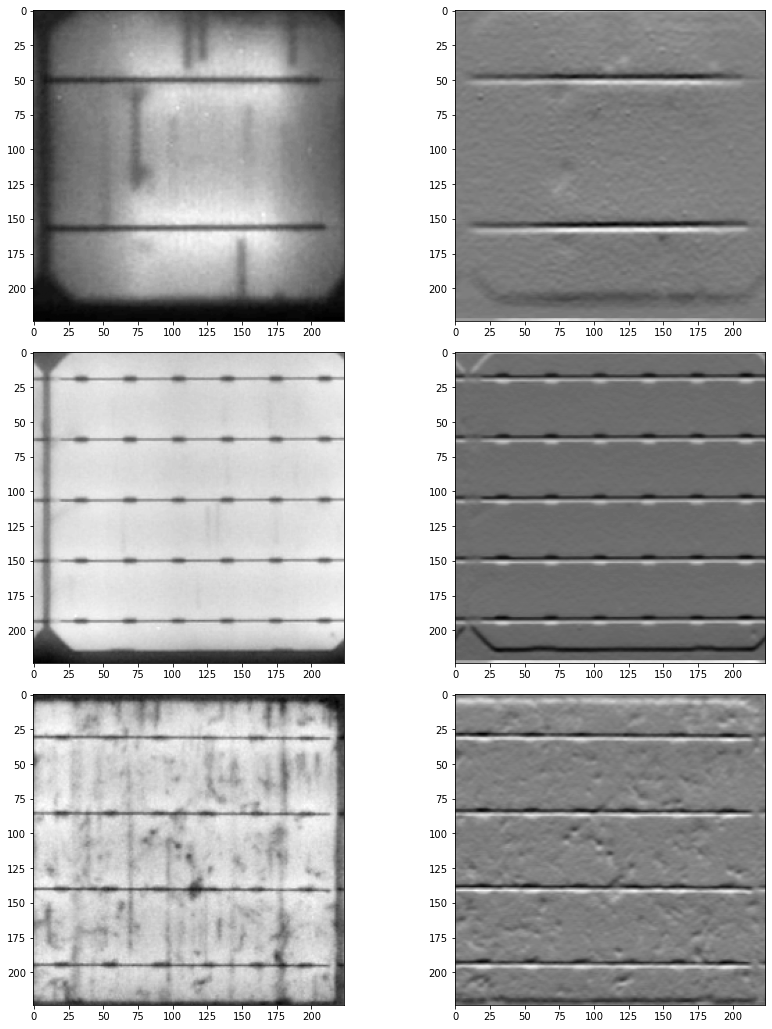

In [13]:
custom_filter = np.array([[1,2,2,1],[0,0,0,0],[0,0,0,0],[-1,-2,-2,-1]])

gaussian = Show(do_show=True) << (Convolve(axis=-2, mode='wrap') \
                                 << (CreateKernel(dim=2, kernel='custom', convolve_mode='full',
                                                  boundary='wrap', custom_kernel=custom_filter) \
                                     << images))